In [162]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

geo = "GSE111803"

In [163]:
threshold = 1000

In [164]:
data = pd.read_csv("../Dataset/Yao2019/data.txt", sep="\t")

In [165]:
data.columns

Index(['miRNA_ID', 'LC11.readcount', 'LC3.readcount', 'LC4.readcount',
       'LC5.readcount', 'LC6.readcount', 'NC1.readcount', 'NC2.readcount',
       'NC3.readcount', 'NC4.readcount', 'NC5.readcount', 'LC11.tpm',
       'LC3.tpm', 'LC4.tpm', 'LC5.tpm', 'LC6.tpm', 'NC1.tpm', 'NC2.tpm',
       'NC3.tpm', 'NC4.tpm', 'NC5.tpm'],
      dtype='object')

In [166]:
table = data.iloc[:, 11:].transpose()
mirnas = data.iloc[:, 0]
table

,0,1,2,3,4,5,6,7,8,9,...,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253
LC11.tpm,84.810449,35945.49515,2.019296,6601.079920,0.000000,1524.568779,438.187318,6187.124158,2.019296,448.283800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.019296,0.000000,0.000000
LC3.tpm,81.564623,24061.56385,8.718977,4780.811951,0.000000,1379.004647,408.385631,5804.307343,0.843772,542.545373,...,0.281257,0.562515,1.687544,0.562515,0.281257,0.281257,0.281257,0.281257,0.000000,0.000000
LC4.tpm,116.614493,34847.67075,8.150475,5837.621215,0.626960,1502.822259,378.683623,8105.961195,0.626960,750.470690,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LC5.tpm,91.876345,28593.96015,15.312724,10165.096690,0.000000,1686.951773,579.331395,5576.383696,0.000000,201.617534,...,2.552121,2.552121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LC6.tpm,81.566355,33601.82989,21.049382,11863.080790,0.000000,1524.326069,504.308107,6267.453446,3.508230,366.610067,...,0.000000,0.000000,2.631173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC1.tpm,57.658187,27294.59926,6.552067,4589.067484,0.000000,794.110478,517.613266,5409.386229,5.241653,681.414932,...,1.310413,0.000000,0.000000,0.000000,1.310413,0.000000,0.000000,0.000000,0.000000,1.310413
NC2.tpm,60.758241,23345.52549,5.523476,4267.437891,0.000000,1277.027751,407.632561,4757.922598,0.000000,269.545650,...,0.000000,0.000000,0.000000,0.000000,2.209391,4.418781,0.000000,0.000000,0.000000,1.104695
NC3.tpm,65.481015,27197.75136,2.931986,3570.181314,0.000000,1040.854941,397.446957,5409.187931,0.651552,430.350353,...,0.977329,0.325776,0.000000,0.000000,0.000000,0.325776,0.000000,0.325776,0.325776,0.000000
NC4.tpm,53.163034,25408.60776,9.968069,5724.994268,0.000000,1162.941378,348.882413,4113.489788,0.000000,624.665654,...,3.322690,0.000000,0.000000,3.322690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC5.tpm,97.619309,24992.46983,2.568929,4310.663175,0.642232,1364.743631,474.609667,4970.235744,1.284465,880.500479,...,1.284465,0.642232,0.642232,0.000000,0.642232,0.642232,0.000000,0.000000,0.000000,0.000000


In [167]:
mask = table.mean() > threshold
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [168]:
controls = np.array(["NC" in c for c in table.index])
sick = 1 - controls

### Mean-variance-plot

In [169]:
np.mean(table)

1       28528.947349
3        6171.003470
5        1325.735171
7        5660.145213
12      44921.677314
            ...     
1162     5083.049724
1167     1162.511821
1181     1930.759968
1183     2172.383784
1185     1206.273371
Length: 74, dtype: float64

In [170]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [171]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

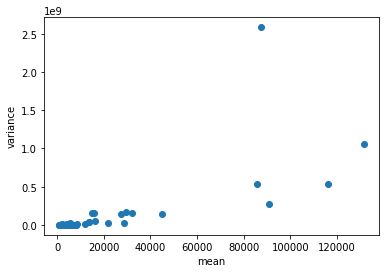

In [172]:
mean_variance_plot(table)

### Log transformation

In [173]:
log_table = np.log2(table + 1e-6)

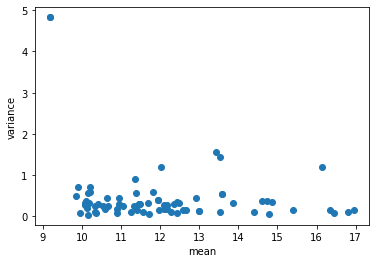

In [174]:
mean_variance_plot(log_table)

In [175]:
mask = log_table.var() < 20
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Standardizing

In [176]:
norm_log_table = log_table - np.mean(log_table)

In [177]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

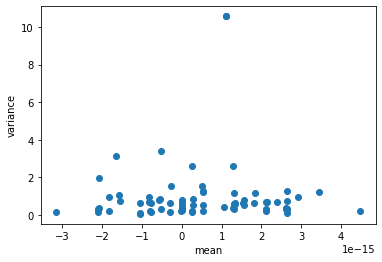

In [178]:
mean_variance_plot(norm_log_table)

In [179]:
norm_log_table.isna().sum().sum()

0

### PCA

In [180]:
pca = decomposition.PCA(n_components=10)

In [181]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [182]:
pca.explained_variance_ratio_

array([5.38018615e-01, 2.20681006e-01, 7.76408018e-02, 4.90695865e-02,
       4.06590909e-02, 3.92463948e-02, 1.63221671e-02, 1.31999500e-02,
       5.16238718e-03, 5.67252496e-33])

In [183]:
components = pca.transform(norm_log_table)

In [184]:
components

array([[-9.07453491e+00, -4.94278099e+00, -1.62978086e+00,
         2.38463015e+00, -4.50841511e-01, -1.40814711e+00,
        -1.25662944e+00,  6.36810651e-01,  1.14677018e-01,
        -2.65300462e-15],
       [ 2.50156930e+00,  3.21600719e+00,  1.91458874e-01,
        -7.77015312e-01, -2.44161419e+00,  1.38723922e+00,
        -8.02194239e-01,  4.95466157e-01,  1.19029312e+00,
         6.44025110e-16],
       [ 1.19363183e+00,  3.63729424e+00, -3.07675788e+00,
        -8.98342668e-01, -9.25342288e-01,  1.16434271e+00,
        -1.05510394e+00, -1.93424756e-01, -1.18451368e+00,
         2.49109607e-16],
       [-5.83946983e+00,  1.34933939e+00, -3.16086434e+00,
        -2.85312633e+00,  1.47858614e+00, -1.33137763e+00,
         1.18952397e+00, -2.64073993e-01,  4.67221123e-01,
         4.17585325e-16],
       [-3.56377086e+00,  6.47605586e+00,  1.49050596e+00,
         2.92607872e+00, -7.25378599e-01, -5.80861938e-01,
         1.57006601e+00,  8.98779741e-02, -2.21121214e-01,
         5.

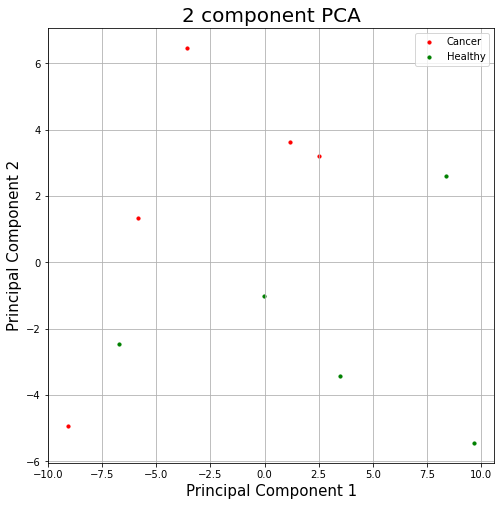

In [185]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [186]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

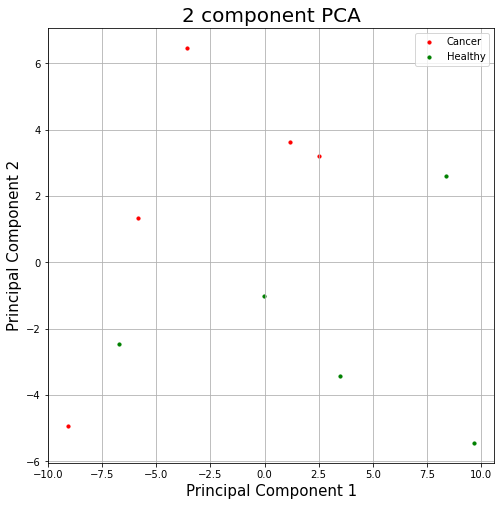

In [187]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [188]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [189]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


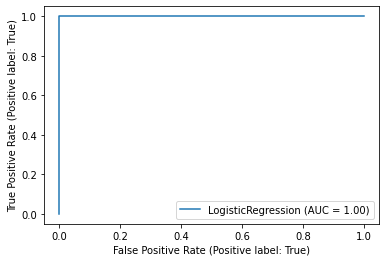

In [190]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [191]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [192]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[16:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


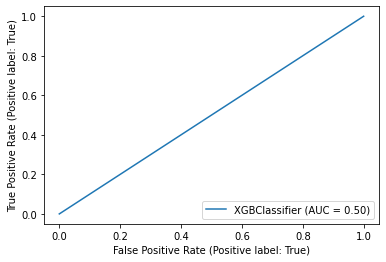

In [193]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [194]:
mirnas[:10]

1       hsa-let-7a-5p
3       hsa-let-7b-5p
5       hsa-let-7c-5p
7       hsa-let-7d-5p
12      hsa-let-7f-5p
14      hsa-let-7g-5p
16      hsa-let-7i-5p
18     hsa-miR-101-3p
21    hsa-miR-103a-3p
22       hsa-miR-103b
Name: miRNA_ID, dtype: object

In [195]:
from Scripts import converters

In [196]:
sequences = converters.canonical_to_seq(mirnas, True)

In [197]:
sequences = np.array(sequences)

In [198]:
mirnas[sequences == None]

Series([], Name: miRNA_ID, dtype: object)

In [199]:
mask = sequences != None
sequences = sequences[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [200]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,UGAGGUAGUAGGUUGUAUAGUU,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,UGAGGUAGUAGUUUGUGCUGUU,UACAGUACUGUGAUAACUGAA,AGCAGCAUUGUACAGGGCUAUGA,UCAUAGCCCUGUACAAUGCUGCU,...,CGGGGCAGCUCAGUACAGGAU,UCCUGUACUGAGCUGCCCCGAG,UGCGGGGCUAGGGCUAACAGCA,UGGAAGACUAGUGAUUUUGUUGUU,UAUUGCACUUGUCCCGGCCUGU,CAAAGUGCUGUUCGUGCAGGUAG,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
LC11.tpm,0.517366,0.300962,0.342723,0.222614,0.503700,-0.460835,0.483533,-0.750360,-0.430347,-0.437142,...,0.091297,0.097326,0.077452,0.903782,-0.122862,-0.952078,0.709969,1.196077,-0.311027,1
LC3.tpm,-0.339066,-0.387410,0.128610,0.086336,-0.357040,0.190676,-0.184653,0.548715,-0.112049,-0.106431,...,1.197095,1.111572,0.119516,-0.895506,-0.717518,0.104514,-0.360827,-0.377652,-0.222368,1
LC4.tpm,0.451185,0.038712,0.312069,0.798983,0.220560,0.078144,-0.047056,0.330236,-0.326228,-0.324610,...,1.069670,1.025629,-0.401303,0.234537,-0.218615,0.030290,0.210324,-1.318184,-0.334159,1
LC5.tpm,0.029164,1.222126,0.558676,0.000862,-0.759728,-1.234527,0.196511,0.372850,-1.150092,-1.157956,...,1.179893,1.142824,0.365281,0.993007,0.667537,-0.175233,0.528115,0.557339,-0.999779,1
LC6.tpm,0.373507,1.551718,0.342383,0.250138,-0.697438,-0.903929,-0.286812,-1.017400,-0.724773,-0.725442,...,3.024845,2.920671,-0.642415,-0.535647,0.590207,0.468181,0.031911,-0.606935,0.013652,1


In [201]:
norm_log_table.to_csv(f"../TransformedData/Yao2019_threshold_{threshold}.csv", index=False)